# **Solving an electricity generation problem using indicator constraints**

***unitcommitment_indicators.ipynb***

This example shows how to model and solve an electricity generation problem typically found in power markets (see [Garver (1963)](https://ieeexplore.ieee.org/document/4501405)), showcasing the use of indicator constraints to model change state constraints when generators are turned on/off.

&copy; Copyright 2025-2026 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://www.fico.com/en/shrinkwrap-license-agreement-fico-xpress-optimization-suite-on-premises) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the necessary packages
%pip install -q xpress matplotlib

## Problem description

Four types of power generators are available to meet daily electricity demand and a security reserve of at least 20% above the estimated demand. Each type of generator has a set minimum and maximum power output.
A generator can only be started or stopped at the beginning of a time period. The objective is to determine which generators should be used, and at which power level, in each period so that total daily cost is minimized.

The length and anticipated daily electricity demand for each of the seven planning periods of uneven length are as follows:

| Time Period | Length (hours) | Demand (MW) |
| --- | --- | --- |
| 00h to 06h | 6 | 12000 |
| 06h to 09h  | 3 | 32000 |
| 09h to 12h  | 3 | 25000 |
| 12h to 14h  | 2 | 36000 |
| 14h to 18h | 4 | 25000 |
| 18h to 22h | 4 | 30000 |
| 22h to 00h | 2 | 18000 |

The characteristics of power generators are described in the table below, per generator type:

| Type | No. units | Min. power | Max. power | Start-up cost | Hourly cost at min. output | Hourly cost per MW above min. output|
| --- | --- | --- | --- | --- | --- | --- |
| A | 10 | 750 | 1750 | 5000 | 2250 | 2.7 |
| B | 4 | 1000 | 1500 | 1600 | 1800 | 2.2 |
| C | 8 | 1200 | 2000 | 2400 | 3750 | 1.8 |
| D | 3 | 1800 | 3500 | 1200 | 4800 | 3.8 |

## Model formulation

Three arrays of binary variables are required to determine when to 'start' and 'stop' generators, and decide which ones are set to 'work' in each time period. Another set of real variables are introduced to represent the additonal energy production ('padd') of each working unit type above its minimum output level. Variable 'start' is the difference between 'work' in a time period and 'work' in any preceding period, and 'stop' is the difference between 'work' in any previous time period and the current one.

This unit commitment problem can be mathematically formulated as follows:
$$\min \sum_{u \in UNITS} \sum_{t \in PERIODS} COST_{S_u}^{\rm start} \cdot start_{u,t} + LEN_t \cdot (COST_{S_u}^{\rm min} \cdot work_{u,t} + COST_{S_u}^{\rm add} \cdot padd_{u,t}) 
+ \sum_{u \in UNITS} \sum_{t \in PERIODS} stop_{u,t} \cdot PEN $$

Subject to:

$$
\begin{array}{llll}
& \hbox{If generator starts in period:} \\
& \qquad start_{u,t}  \geq work_{u,t}  - work_{u,n} , \qquad \forall u \in UNITS, \forall t \in PERIODS, n = (NT+t-1) \hbox{ \% } NT \\
& \qquad start_{u,t}  \leq work_{u,t}  , \qquad \forall u \in UNITS, \forall t \in PERIODS \\
& \hbox{If generator stops in period:} \\
& \qquad stop_{u,t}  \geq work_{u,n}  - work_{u,t} , \qquad \forall u \in UNITS, \forall t \in PERIODS, n = (NT+t-1) \hbox{ \% } NT \\
& \qquad stop_{u,t}  \leq 1 - work_{u,t}, \qquad \forall u \in UNITS, \forall t \in PERIODS \\
& \hbox{Limit on power production above minimum level:} \\
& \qquad padd_{u,t}\leq (P_{S_u}^{\rm max}-P_{S_u}^{\rm min}) \cdot work_{u,t}, \qquad \forall u \in UNITS, \forall t \in PERIODS \\
& \hbox{Satisfy daily electricity demand:} \\
& \qquad \sum_{u \in UNITS} P_{S_u}^{\rm min} \cdot work_{u,t} +  padd_{u,t} \geq D_t, \qquad \forall t \in PERIODS \\
& \hbox{Ensure security reserve of 20\%:} \\
& \qquad \sum_{u \in UNITS} P_{S_u}^{\rm max} \cdot work_{u,t} \geq 1.20 \cdot D_t, \qquad \forall t \in PERIODS \\
\end{array}
$$

Where:
* $NT$ = number of time periods ($NT = |PERIODS|$)
* $PERIODS$ = set of time periods ($t \in PERIODS$)
* $TYPES$ = set of generator types ($s \in TYPES$)
* $UNITS$ = set of unit generators to be committed ($u \in UNITS$)
* $AVAIL_s$ = available number of type $s$ generators ($|UNITS| = \sum_{s \in TYPES} AVAIL_s$)
* $LEN_t$ = length of time period $t$
* $DEM_t$ = demand in time period $t$
* $TYPE_u$ = type of generator $u$
* $COST_{s}^{\rm start}$ = start-up cost of generator type $s$
* $COST_{s}^{\rm min}$ = hourly cost of operating generator $s$ at minimum output
* $COST_{s}^{\rm add}$ = cost/hour/MW of prod. above min. level
* $POW_{s}^{\rm min}$,$POW_{s}^{\rm max}$ = minimum and maximum power output of a generator type $s$
* $PEN$ = penalty to ensure that stop variables are 0 when not needed

The decision variables are:
* $start_{u,t}$ = 1 if generator $u$ is started in period $t$, 0 otherwise
* $stop_{u,t}$ = 1 if generator $u$ is stopped in period $t$, 0 otherwise
* $work_{u,t}$ = 1 if generator $u$ is working during period $t$, 0 otherwise
* $padd_{u,t}$ = production level (MW) of generator $u$ above the minimum level $P_{S_u}^{\rm min}$ in period $t$

## Implementation of the basic model

The code cell below demonstrates the implementation of the above model formulation and prints the results using the Xpress Python interface.

In [ ]:
import xpress as xp
import matplotlib.pyplot as plt
import numpy as np

# Time periods
LEN = [6, 3, 3, 2, 4, 4, 2]
DEM = [12000, 32000, 25000, 36000, 25000, 30000, 18000]

# Power plants
PMIN = [750, 1000, 1200, 1800]      # minimum output (MW) per generator type
PMAX = [1750, 1500, 2000, 3500]     # maximum output (MW) per generator type
CSTART = [5000, 1600, 2400, 1200]   # start-up cost per generator type
CMIN = [2250, 1800, 3750, 4800]     # hourly cost of operating generator type at minimum output (see PMIN)
CADD = [2.7, 2.2, 1.8, 3.8]         # cost/hour/MW of prod. above min. level per generator type
AVAIL = [10, 4, 8, 3]               # number of units per type

NT = 7                              # number of time periods
PERIODS = range(NT)                 # set of time periods
TYPES = range(4)                    # power generator types
UNITS = range(sum(AVAIL))           # power generation units
TYPE = [i for i in TYPES for p in range(AVAIL[i])]      # associating units with types
PEN = 0.1                           # penalty associated with stopping units

# Create problem
p = xp.problem("Unit commitment")

# Create decision variables
start = p.addVariables(UNITS, PERIODS, vartype=xp.binary, name='start')
stop = p.addVariables(UNITS, PERIODS, vartype=xp.binary, name='stop')
work = p.addVariables(UNITS, PERIODS, vartype=xp.binary, name='work')
padd = p.addVariables(UNITS, PERIODS, name='padd')

# If generator starts in period
p.addConstraint(start[u,t] >= work[u,t] - work[u,(NT+t-1) % NT] for u in UNITS for t in PERIODS)
p.addConstraint(start[u,t] <= work[u,t]  for u in UNITS for t in PERIODS)

# If generator stops before period
p.addConstraint(stop[u,t] >= work[u,(NT+t-1) % NT] - work[u,t] for u in UNITS for t in PERIODS)
p.addConstraint(stop[u,t] <= 1 - work[u,t] for u in UNITS for t in PERIODS)

# Limit on power production above minimum level
p.addConstraint(padd[u,t] <= (PMAX[TYPE[u]]-PMIN[TYPE[u]]) * work[u,t] for u in UNITS for t in PERIODS)

# Satisfy demands
p.addConstraint(xp.Sum(PMIN[TYPE[u]]*work[u,t] + padd[u,t] for u in UNITS) >= DEM[t] for t in PERIODS)

# Security reserve of 20%
p.addConstraint(xp.Sum(PMAX[TYPE[u]]*work[u,t] for u in UNITS) >= 1.20 * DEM[t] for t in PERIODS)

# Create and add the oObjective function of the problem (hint: compute 'daily cost' and 'penalty' separately)
Cost = xp.Sum(CSTART[TYPE[u]] * start[u,t] +
          LEN[t] * (CMIN[TYPE[u]] * work[u,t] + CADD[TYPE[u]] * padd[u,t]) for u in UNITS for t in PERIODS)

Penalty = PEN * xp.Sum(stop[u,t] for u in UNITS for t in PERIODS)
p.setObjective(Cost + Penalty)

# Optimize the problem and print the daily cost, penalty and total objective value
p.optimize()
print("Daily cost:", round(p.getSolution(Cost),2))
print("Penalty:", round(p.getSolution(Penalty),2))
print("Objective value:", round(p.attributes.objval,2))

Next we define a function to print the solution in a user-friendly way.

In [2]:
# Display solution
def print_sol(prob):
    ct = 0
    print(f"Time period          ", end="")
    for t in PERIODS:
        print('{:5d}-{:2}'.format(ct,ct+LEN[t]), end="")
        ct += LEN[t]

    for u in UNITS:
        print("\n",f"\nUnit {u+1} Working      ", end="")
        for t in PERIODS:
            print("     off" if prob.getSolution(work[u,t]) == 0 else "      on", end="")
        print("\n       Status change", end="")
        for t in PERIODS:
            if prob.getSolution(stop[u,t]) > 0.5: print("    stop", end="")
            else:
                if prob.getSolution(start[u,t]) > 0.5: print("    start", end="")
                else: print("       -", end="")
        print("\n       Total output ", end="")
        for t in PERIODS:
            print('{:8d}'.format(round(prob.getSolution(PMIN[TYPE[u]]*work[u,t] + padd[u,t]))), end="")
        print("\n       of which add.", end="")
        for t in PERIODS:
            print('{:8d}'.format(round(prob.getSolution(padd[u,t]))), end="")

print_sol(p)

Time period              0- 6    6- 9    9-12   12-14   14-18   18-22   22-24
 
Unit 1 Working            on      on      on      on      on      on      on
       Status change       -       -       -       -       -       -       -
       Total output      750     750     750     750     750     750     750
       of which add.       0       0       0       0       0       0       0
 
Unit 2 Working           off     off     off      on     off     off     off
       Status change       -       -       -    start    stop       -       -
       Total output        0       0       0     750       0       0       0
       of which add.       0       0       0       0       0       0       0
 
Unit 3 Working            on      on      on      on      on      on      on
       Status change       -       -       -       -       -       -       -
       Total output      750     750     750    1750     750     750     750
       of which add.       0       0       0    1000       0       0

Now we use the *matplotlib* pacakge to define a function that plots a bar chart with stacked bars of hourly power output per generator type per time period, the total power output and the total demand in each planning period. 

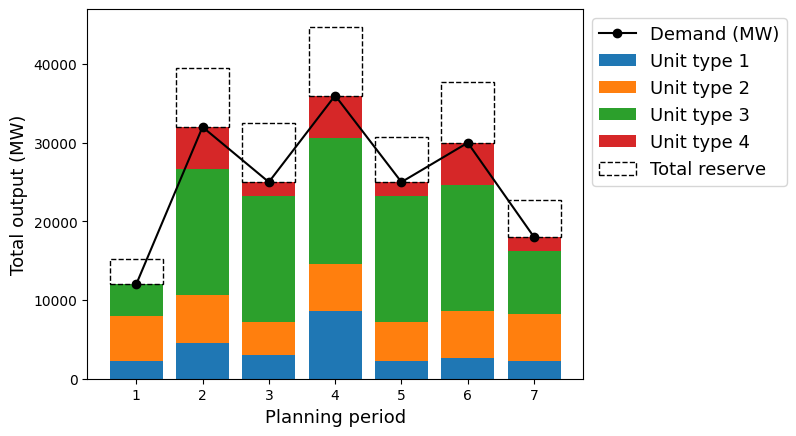

In [3]:
def plot_sol(prob):

    # Get the total power output per generator type per planning period
    outputs = [[0 for _ in PERIODS] for _ in TYPES]
    reserve = [0 for _ in PERIODS]
    for i in TYPES:
        for t in PERIODS:
            for u in UNITS:
                if TYPE[u] == i and prob.getSolution(work[u,t]) > 0.5:
                        power_output = prob.getSolution(PMIN[TYPE[u]]*work[u,t] + padd[u,t])
                        outputs[i][t] += power_output
                        reserve[t] += PMAX[TYPE[u]] - power_output
            
    # Labels for the unit types
    labels = [f"Unit type {i + 1}" for i in TYPES]

    # Create a stacked bar chart
    fig, ax = plt.subplots()

    # Plot output for each unit type per planning period
    for i in range(len(outputs)):
        ax.bar(range(1,NT+1), outputs[i], label=labels[i], bottom=np.sum(outputs[:i], axis=0))

    # Plot the total reserve per planning period
    ax.bar(range(1,NT+1), reserve, label='Total reserve', bottom=np.sum(outputs, axis=0), fill=False, edgecolor='black', linestyle='--')

    # Plot the demand data as a line
    ax.plot(range(1,NT+1), DEM, color='black', marker='o', label='Demand (MW)')

    # Label and size the axes
    ax.set_xlabel('Planning period', fontsize=13)
    ax.set_ylabel('Total output (MW)', fontsize=13)

    # Add a legend
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=13)

    # Show the plot
    plt.show()

plot_sol(p)

## Adding indicator constraints

In real-world applications, generators must often remain for some time in a certain state after they have been switched to that state, i.e. if a generator is turned ON/OFF, it must remain in that state for at least $ON_s^{\rm min}$/$OFF_s^{\rm min}$ periods, respectively. Such state change constraints can be formulated with the help of so-called **indicator constraints** as their enforcement depends on the value of a binary variable, called the 'indicator'.

The indicator constraints for this problem can be formulated as follows:

$$
\begin{align*}
& \hbox{Can only switch OFF at least $ON_s^{\rm min}$ periods after it has been turned ON:} \\
& \qquad \sum_{j=t+1}^{t+ON_s^{\rm min}-1} stop_{u,(j \hbox{ \% } NT)}  \leq 0, \qquad \forall u \in \mathcal{U}, \forall t \in \mathcal{T}: start_{u,t} = 1 \\
& \hbox{Can only switch ON at least $OFF_s^{\rm min}$ periods after it has been turned OFF:} \\
& \qquad \sum_{j=t+1}^{t+OFF_s^{\rm min}-1} start_{u,(j \hbox{ \% } NT)}  \leq 0, \qquad \forall u \in \mathcal{U}, \forall t \in \mathcal{T}: stop_{u,t} = 1 \\
\end{align*}
$$

where $ON_s^{\rm min}$,$OFF_s^{\rm min}$ = minimum time intervals a generator type $s$ must be ON/OFF once it has switched to that state, respectively.

Indicator constraints can conveniently be added by using the [problem.addIndicator()](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/chModeling.html?scroll=secModelingIndicator) method (note the "==" as the symbol for the equality on the indicator).

The code cell below adds the indicator constraints to the model, triggers the optimization again and prints the solution. Comparing the outcomes with those from the previous code cells, we can verify that there is an extra cost by introducing the new constraints, as now units are not allowed to be turned ON and then OFF within three time periods. Also note that the indicators make the problem more difficult (hence slower) to solve.

Daily cost: 1505300.0
Penalty: 1.1
Objective value: 1505301.1
Time period              0- 6    6- 9    9-12   12-14   14-18   18-22   22-24
 
Unit 1 Working            on      on      on      on      on      on      on
       Status change       -       -       -       -       -       -       -
       Total output      750    1750     750     750     750     750     750
       of which add.       0    1000       0       0       0       0       0
 
Unit 2 Working            on      on      on      on      on      on      on
       Status change       -       -       -       -       -       -       -
       Total output      750    1750     750     750     750     750     750
       of which add.       0    1000       0       0       0       0       0
 
Unit 3 Working            on      on      on      on      on      on      on
       Status change       -       -       -       -       -       -       -
       Total output      750     750     750     750     750     750     750
       

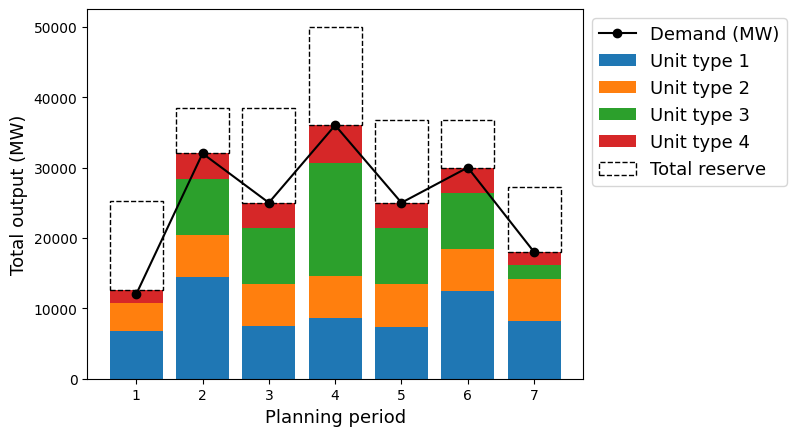

In [4]:
# Minimum time 
ONMIN = [3, 3, 3, 3]                # minimum time intervals a generator type $s$ must be ON once switched to that state
DWMIN = [3, 3, 3, 3]                # minimum time intervals a generator type $s$ must be OFF once switched to that state

# Indicator constraints
for u in UNITS:
    for t in PERIODS:
        # Can only switch off at least ONMIN periods later
        p.addIndicator(start[u,t] == 1, xp.Sum(stop[u,j % NT] for j in range(t+1,t+ONMIN[TYPE[u]])) <= 0)
        # Can only switch on at least DWMIN periods later
        p.addIndicator(stop[u,t] == 1, xp.Sum(start[u,j % NT] for j in range(t+1,t+DWMIN[TYPE[u]])) <= 0)

# Re-optimize the problem and print the daily cost, penalty and total objective value
p.controls.outputlog = 0
p.optimize()
print("Daily cost:", round(p.getSolution(Cost),2))
print("Penalty:", round(p.getSolution(Penalty),2))
print("Objective value:", round(p.attributes.objval,2))

print_sol(p)
plot_sol(p)